# Summary:
* This project analyzes the most-viewed Wikipedia pages in 2024 using data from the bigquery pageviews_2024 dataset. The dataset includes hourly pageview statistics for Wikipedia pages. These are grouped by titles and aggregated to identify the most popular pages.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from matplotlib import cm

In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [6]:
project_id = 'project-123-445717'

In [7]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

## Getting size of dataset

In [8]:
%%bigquery table_size --project project-123-445717
SELECT
  table_id,
  row_count,
  ROUND(size_bytes / 1e9, 2) AS size_gb
FROM `bigquery-public-data.wikipedia.__TABLES__`
WHERE table_id = 'pageviews_2024'
ORDER BY table_id

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
table_size

,table_id,row_count,size_gb
0,pageviews_2024,57599911771,2604.27


***
* the dataset is about 2.6 terabytes.
***

## Previewing dataset

In [10]:
%%bigquery df --project project-123-445717
SELECT *
FROM `bigquery-public-data.wikipedia.pageviews_2024`
WHERE datehour BETWEEN '2024-01-01 00:00:00' AND '2024-12-01 23:59:59'
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [11]:
df.head()

,datehour,wiki,title,views
0,2024-10-07 16:00:00+00:00,cs.d,zákon,1
1,2024-10-07 16:00:00+00:00,cs.s,Ottův_slovník_naučný/Deklinace,1
2,2024-10-07 16:00:00+00:00,cs.m.b,Zvířecí_abeceda/E,1
3,2024-10-07 16:00:00+00:00,cs.d,mensis,1
4,2024-10-07 16:00:00+00:00,cy.s,Defnyddiwr:AleiPhoenix,1


## Just want the wiki pages in English

In [12]:
%%bigquery df --project project-123-445717
SELECT *
FROM `bigquery-public-data.wikipedia.pageviews_2024`
WHERE datehour BETWEEN '2024-01-01 00:00:00' AND '2024-12-01 23:59:59' AND wiki='en'
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [13]:
df.head()

,datehour,wiki,title,views
0,2024-08-25 17:00:00+00:00,en,Meyer_Lansky,21
1,2024-08-25 17:00:00+00:00,en,Renault_Mégane,11
2,2024-08-25 17:00:00+00:00,en,Rupert_von_Trapp,19
3,2024-08-25 17:00:00+00:00,en,Shah_Jahan,31
4,2024-08-25 17:00:00+00:00,en,Through_the_Darkness_(TV_series),11


## Dropping 'wiki' and changing 'datehour' to date

In [14]:
%%bigquery df --project project-123-445717
SELECT
  DATE(datehour) AS date,
  title,
  views
FROM `bigquery-public-data.wikipedia.pageviews_2024`
WHERE wiki = 'en'
  AND datehour BETWEEN '2024-01-01 00:00:00' AND '2024-12-01 23:59:59'
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [15]:
df.head()

,date,title,views
0,2024-11-03,Second_East_Turkestan_Republic,12
1,2024-11-03,Sex_Pistols,30
2,2024-11-03,Shotgun,26
3,2024-11-03,Smolensk,12
4,2024-11-03,Pax_Romana,13


## Grouping by title & grabbing top 10

In [18]:
%%bigquery top_titles --project project-123-445717
SELECT
  title,
  SUM(views) AS total_views
FROM `bigquery-public-data.wikipedia.pageviews_2024`
WHERE wiki = 'en'
  AND datehour BETWEEN '2024-01-01 00:00:00' AND '2024-12-31 23:59:59'
GROUP BY title
ORDER BY total_views DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

In [21]:
top_titles.head()

,title,total_views
0,Main_Page,727154119
1,Special:Search,504978155
2,-,349733444
3,Deaths_in_2024,22481746
4,YouTube,17594120



## Dropping main_page, special:search, and -

In [30]:
top_titles = top_titles[~top_titles['title'].isin(['Main_Page', 'Special:Search','-'])].reset_index(drop=True)

In [31]:
top_titles.shape

(17, 2)

## Results

In [32]:
top_titles

,title,total_views
0,Deaths_in_2024,22481746
1,YouTube,17594120
2,Portal:Current_events,13253436
3,2024_United_States_presidential_election,11925122
4,ChatGPT,11026677
5,Biggest_ball_of_twine,10019444
6,Raindrop_cake,8850166
7,Kepler's_Supernova,8598941
8,Deadpool_&_Wolverine,8302419
9,Donald_Trump,7928827


## Visualizing Results

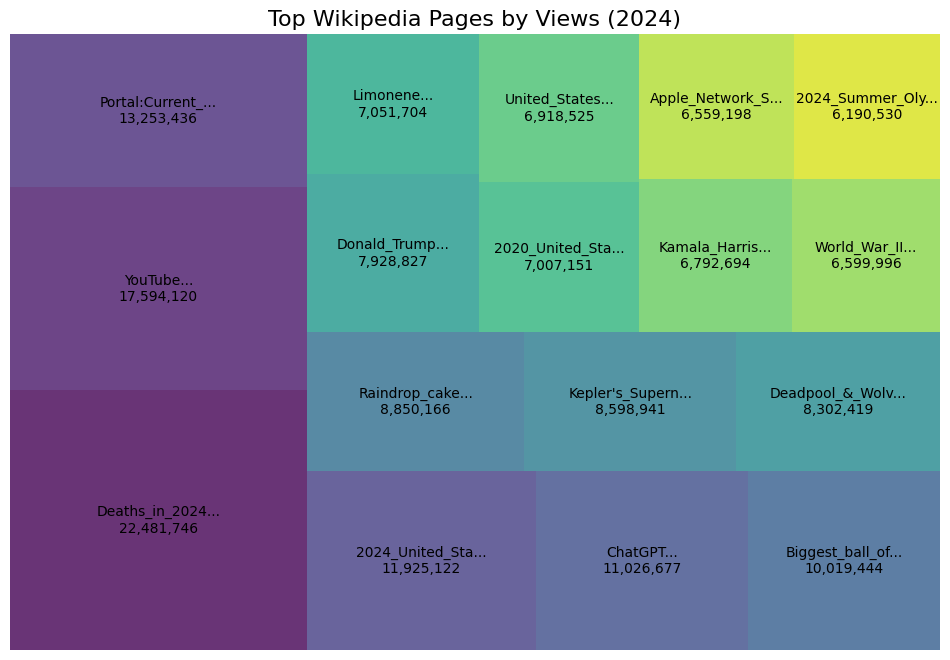

In [51]:
sizes = top_titles['total_views']
labels = [f"{title[:15]}...\n{views:,}" for title, views in zip(top_titles['title'], sizes)]

colors = cm.viridis([i / len(sizes) for i in range(len(sizes))])

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize': 10})
plt.axis('off')
plt.title("Top Wikipedia Pages by Views (2024)", fontsize=16)
plt.show()